<a href="https://colab.research.google.com/github/adhiraj141092/mir_comp/blob/main/mir_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!git clone https://github.com/adhiraj141092/mir_comp.git

fatal: destination path 'mir_comp' already exists and is not an empty directory.


In [2]:
!pip install biopython
!pip install viennarna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 36.0 MB/s eta 0:00:00


In [5]:
import os
import pandas as pd
import re
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import itertools
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [6]:
from Bio import SeqIO
import RNA

fasta_file = "/content/mir_comp/raw_data/insect.fasta"
output_file = "/content/mir_comp/processes/insect_res.fold"

with open(output_file, "w") as f_out:
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_id = record.id
        seq = str(record.seq).upper()

        fc = RNA.fold_compound(seq)
        ss, mfe = fc.mfe()

        f_out.write(f">{seq_id}\n{seq}\n{ss} ({mfe:6.2f})\n\n")


In [ ]:
!ls

mir_comp  sample_data


In [15]:
!perl mir_comp/genRNAStats.pl < mir_comp/raw_data/insect.fasta > mir_comp/processes/insect_stats.csv

Can't locate RNA.pm in @INC (you may need to install the RNA module) (@INC contains: /home/stanley/ViennaRNA-1.5/Perl/blib/lib /home/stanley/ViennaRNA-1.5/Perl/blib/arch /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.34.0 /usr/local/share/perl/5.34.0 /usr/lib/x86_64-linux-gnu/perl5/5.34 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl-base /usr/lib/x86_64-linux-gnu/perl/5.34 /usr/share/perl/5.34 /usr/local/lib/site_perl) at mir_comp/genRNAStats.pl line 10.
BEGIN failed--compilation aborted at mir_comp/genRNAStats.pl line 10.


In [8]:
def preprocess(organism):
  org_stats = pd.read_csv(f'mir_comp/processes/{organism}_stats.csv', sep='\t')
  org_stats = org_stats.fillna(0)

  qi = open(f"mir_comp/processes/{organism}_res.fold", "r")

  text = qi.readlines()
  qi.close()
  text_str = ''.join(text)
  match1 = re.findall("[(.][.)(]+[.)]", text_str)
  match2 = re.findall(r"^>.*\n([AUGC\n]+)", text_str, re.MULTILINE)

  df01 = pd.DataFrame(match1, match2)
  df01 = df01.reset_index()
  df01.columns = ["sequence","fold"]
  scon = pd.concat([org_stats, df01], axis=1)
  scon.rename(columns={"Nmfe": "dG"}, inplace=True)
  scon["stem"] = scon["fold"].str.extract('(\(.*\))')
  scon["nstem"] = scon["stem"].apply(len)
  scon["stemte"] = scon["fold"].str.findall('(\(\.+\))')
  scon["nstemte"] = scon["stemte"].apply(len)
  scon["stemte"] = scon["fold"].str.extract('(\(\.+\))')
  scon["lenstemte"] = scon["stemte"].apply(len)

  scon["MFE1"] = scon["dG"] / scon["%G+C"]
  scon["stem0"] = scon["fold"].str.findall('(\({3,})')
  scon["n_stems"] = scon["stem0"].apply(len)
  scon["stem1"] = scon["fold"].str.findall('(\()')
  scon["total_base"] = scon["stem1"].apply(len)
  scon["MFE2"] = scon["dG"] / scon["n_stems"]
  scon["MFE3"] = scon["dG"] / scon["nstemte"]
  scon["MFE4"] = scon["dG"] / scon["total_base"]
  scon["avg_bp"] = scon["total_base"] / scon["n_stems"]
  columns_to_keep = [
    'Len', 'A', 'C', 'G', 'U', 'G+C', 'A+U',
    'AA', 'AC', 'AG', 'AU', 'CA', 'CC', 'CG', 'CU',
    'GA', 'GC', 'GG', 'GU', 'UA', 'UC', 'UG', 'UU',
    '%A', '%C', '%G', '%U', '%G+C', '%A+U',
    '%AA', '%AC', '%AG', '%AU', '%CA', '%CC', '%CG', '%CU',
    '%GA', '%GC', '%GG', '%GU', '%UA', '%UC', '%UG', '%UU',
    'pb', 'Npb', 'mfe', 'dG', 'Q', 'NQ', 'D', 'ND', 'MFE1',
    'MFE2','MFE3','MFE4']
  scon_fil = scon[columns_to_keep]
  print(f'Shape for: {organism}: {scon_fil.shape}')
  return scon_fil

In [12]:
aves_df = preprocess(organism='aves')
human_df = preprocess(organism='human')
mammalia_df = preprocess(organism='mammalia')
monocots_df = preprocess(organism='monocots')
rodent_df = preprocess(organism='rodent')
rumin_df = preprocess(organism='rumin')
sauria_df = preprocess(organism='sauria')
insect_df =preprocess(organism='insect')

Shape for: aves: (1381, 57)
Shape for: human: (1916, 57)
Shape for: mammalia: (502, 57)
Shape for: monocots: (910, 57)
Shape for: rodent: (1580, 57)
Shape for: rumin: (1064, 57)
Shape for: sauria: (606, 57)


EmptyDataError: No columns to parse from file

In [ ]:
dfs = {
    'aves': aves_df,
    'human': human_df,
    'mammalia': mammalia_df,
    'monocots': monocots_df,
    'rodent': rodent_df,
    'rumin': rumin_df,
    'sauria': sauria_df,
    'insect': insect_df
}

In [ ]:
# List of features
features = aves_df.columns  # 57 features

# Significance level for normality
alpha = 0.05

# Store Shapiro-Wilk p-values
normality_results = []

for feature in features:
    result = {'Feature': feature}
    for org, df in dfs.items():
        data = df[feature].dropna()
        if len(data) > 3:  # Shapiro-Wilk requires at least 3 samples
            _, p_value = stats.shapiro(data)
            result[org] = p_value
        else:
            result[org] = np.nan  # Not enough data
    normality_results.append(result)

# Convert to DataFrame
normality_df = pd.DataFrame(normality_results)

# Determine if each feature is Gaussian for all organisms
normality_df['All_Gaussian'] = normality_df[list(dfs.keys())].gt(alpha).all(axis=1)
normality_df['Any_Non_Gaussian'] = normality_df[list(dfs.keys())].le(alpha).any(axis=1)

# Summary
gaussian_features = normality_df[normality_df['All_Gaussian']]['Feature'].tolist()
non_gaussian_features = normality_df[normality_df['Any_Non_Gaussian']]['Feature'].tolist()

# Display results
print("=== Normality Test Results (Shapiro-Wilk) ===")
print(f"\nFeatures Gaussian for ALL organisms (p > {alpha} for all):")
print(gaussian_features)
print(f"Count: {len(gaussian_features)}")

print(f"\nFeatures Non-Gaussian for ANY organism (p ≤ {alpha} for at least one):")
print(non_gaussian_features)
print(f"Count: {len(non_gaussian_features)}")

print("\nDetailed P-values for Each Feature and Organism:")
# Round p-values for readability
display_df = normality_df.copy()
display_df[list(dfs.keys())] = display_df[list(dfs.keys())].round(4)
display_df = display_df[['Feature'] + list(dfs.keys()) + ['All_Gaussian', 'Any_Non_Gaussian']]
print(display_df.to_string(index=False))

# Save results to CSV for reference
normality_df.to_csv('normality_test_results.csv', index=False)
print("\nResults saved to 'normality_test_results.csv'")

=== Normality Test Results (Shapiro-Wilk) ===

Features Gaussian for ALL organisms (p > 0.05 for all):
[]
Count: 0

Features Non-Gaussian for ANY organism (p ≤ 0.05 for at least one):
['Len', 'A', 'C', 'G', 'U', 'G+C', 'A+U', 'AA', 'AC', 'AG', 'AU', 'CA', 'CC', 'CG', 'CU', 'GA', 'GC', 'GG', 'GU', 'UA', 'UC', 'UG', 'UU', '%A', '%C', '%G', '%U', '%G+C', '%A+U', '%AA', '%AC', '%AG', '%AU', '%CA', '%CC', '%CG', '%CU', '%GA', '%GC', '%GG', '%GU', '%UA', '%UC', '%UG', '%UU', 'pb', 'Npb', 'mfe', 'dG', 'Q', 'NQ', 'D', 'ND', 'MFE1', 'MFE2', 'MFE3', 'MFE4']
Count: 57

Detailed P-values for Each Feature and Organism:
Feature   aves  human  mammalia  monocots  rodent  rumin  sauria  insect  All_Gaussian  Any_Non_Gaussian
    Len 0.0000 0.0000    0.0000    0.0000  0.0000 0.0000  0.0000  0.0000         False              True
      A 0.0003 0.0000    0.0000    0.0000  0.0000 0.0002  0.0010  0.0000         False              True
      C 0.0000 0.0000    0.0000    0.0000  0.0000 0.0000  0.0000  0.000

In [ ]:
import pandas as pd
from scipy import stats
import itertools
from statsmodels.stats.multitest import multipletests

# Assume DataFrames are loaded
dfs = {
    'aves': aves_df,
    'human': human_df,
    'mammalia': mammalia_df,
    'monocots': monocots_df,
    'rodent': rodent_df,
    'rumin': rumin_df,
    'sauria': sauria_df,
    'insect': insect_df
}

# List of features
features = aves_df.columns  # 57 features

# Significance level
alpha = 0.05

# Store KS test results
ks_results = []

# Pairwise combinations
pairs = list(itertools.combinations(dfs.keys(), 2))

for feature in features:
    # Collect data for this feature
    data = {org: df[feature].dropna() for org, df in dfs.items()}

    for org1, org2 in pairs:
        x1, x2 = data[org1], data[org2]
        if len(x1) > 1 and len(x2) > 1:  # KS test requires at least 2 samples
            ks_stat, ks_p = stats.ks_2samp(x1, x2)
            result = {
                'Feature': feature,
                'Organism1': org1,
                'Organism2': org2,
                'KS_stat': ks_stat,
                'KS_p': ks_p
            }
            ks_results.append(result)

# Convert to DataFrame
ks_df = pd.DataFrame(ks_results)

# Multiple testing correction (Bonferroni)
ks_df['KS_p_adj'] = multipletests(ks_df['KS_p'], alpha=alpha, method='bonferroni')[1]

# Filter significant results
significant_ks = ks_df[ks_df['KS_p_adj'] < alpha]

# Display results
print("=== Kolmogorov-Smirnov Test Results ===")
print(f"\nSignificant Results (adjusted p < {alpha}):")
print(significant_ks[['Feature', 'Organism1', 'Organism2', 'KS_stat', 'KS_p', 'KS_p_adj']].to_string(index=False))

print(f"\nTotal significant pairs: {len(significant_ks)}")
print(f"Total tests performed: {len(ks_df)}")

# Summarize significant features
significant_features = significant_ks['Feature'].unique()
print(f"\nFeatures with at least one significant pair: {list(significant_features)}")
print(f"Count: {len(significant_features)}")

# Save results
ks_df.to_csv('ks_test_results.csv', index=False)
print("\nResults saved to 'ks_test_results.csv'")

=== Kolmogorov-Smirnov Test Results ===

Significant Results (adjusted p < 0.05):
Feature Organism1 Organism2  KS_stat          KS_p      KS_p_adj
    Len      aves     human 0.187595  3.625937e-25  5.786996e-22
    Len      aves  mammalia 0.275138  4.707091e-25  7.512517e-22
    Len      aves  monocots 0.607077 3.544422e-189 5.656898e-186
    Len      aves    rodent 0.296380  1.333046e-57  2.127541e-54
    Len      aves     rumin 0.325546  7.063634e-57  1.127356e-53
    Len      aves    sauria 0.194339  2.132861e-14  3.404047e-11
    Len      aves    insect 0.108920  5.824519e-11  9.295932e-08
    Len     human  mammalia 0.247848  5.684853e-22  9.073025e-19
    Len     human  monocots 0.666467 1.443656e-261 2.304076e-258
    Len     human    rodent 0.222394  5.168796e-38  8.249398e-35
    Len     human     rumin 0.159902  9.710716e-16  1.549830e-12
    Len     human    sauria 0.307799  4.427017e-39  7.065519e-36
    Len     human    insect 0.242799  1.001781e-66  1.598843e-63
    Len 

In [ ]:
import pandas as pd
from scipy import stats
import itertools
from statsmodels.stats.multitest import multipletests

# Assume DataFrames are loaded
dfs = {
    'aves': aves_df,
    'human': human_df,
    'mammalia': mammalia_df,
    'monocots': monocots_df,
    'rodent': rodent_df,
    'rumin': rumin_df,
    'sauria': sauria_df,
    'insect': insect_df
}

# List of features
features = aves_df.columns  # 57 features

# Significance level
alpha = 0.05

# Store Mann-Whitney U test results
mw_results = []

# Pairwise combinations
pairs = list(itertools.combinations(dfs.keys(), 2))

for feature in features:
    # Collect data for this feature
    data = {org: df[feature].dropna() for org, df in dfs.items()}

    for org1, org2 in pairs:
        x1, x2 = data[org1], data[org2]
        if len(x1) > 1 and len(x2) > 1:  # Mann-Whitney U requires at least 2 samples
            mw_stat, mw_p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
            result = {
                'Feature': feature,
                'Organism1': org1,
                'Organism2': org2,
                'MW_stat': mw_stat,
                'MW_p': mw_p
            }
            mw_results.append(result)

# Convert to DataFrame
mw_df = pd.DataFrame(mw_results)

# Multiple testing correction (Bonferroni)
mw_df['MW_p_adj'] = multipletests(mw_df['MW_p'], alpha=alpha, method='bonferroni')[1]

# Filter significant results
significant_mw = mw_df[mw_df['MW_p_adj'] < alpha]

# Display results
print("=== Mann-Whitney U Test Results ===")
print(f"\nSignificant Results (adjusted p < {alpha}):")
print(significant_mw[['Feature', 'Organism1', 'Organism2', 'MW_stat', 'MW_p', 'MW_p_adj']].to_string(index=False))

print(f"\nTotal significant pairs: {len(significant_mw)}")
print(f"Total tests performed: {len(mw_df)}")

# Summarize significant features
significant_features = significant_mw['Feature'].unique()
print(f"\nFeatures with at least one significant pair: {list(significant_features)}")
print(f"Count: {len(significant_features)}")

# Save results
mw_df.to_csv('mw_test_results.csv', index=False)
print("\nResults saved to 'mw_test_results.csv'")

=== Mann-Whitney U Test Results ===

Significant Results (adjusted p < 0.05):
Feature Organism1 Organism2   MW_stat          MW_p      MW_p_adj
    Len      aves     human 1578238.0  2.867122e-21  4.575927e-18
    Len      aves  monocots  186217.5 3.228658e-179 5.152938e-176
    Len      aves    rodent 1443599.0  3.662969e-52  5.846099e-49
    Len      aves     rumin 1007899.5  3.575012e-56  5.705719e-53
    Len      aves    insect 2456670.0  2.062275e-05  3.291391e-02
    Len     human  monocots  190970.5 1.956219e-247 3.122126e-244
    Len     human    rodent 1792555.0  5.868435e-21  9.366022e-18
    Len     human     rumin 1221452.0  2.600599e-19  4.150556e-16
    Len     human    sauria  388167.0  7.431934e-35  1.186137e-31
    Len     human    insect 2728489.5  6.364495e-59  1.015773e-55
    Len  mammalia  monocots   89218.0  2.515999e-80  4.015534e-77
    Len  mammalia    rodent  453586.0  1.174156e-06  1.873954e-03
    Len  mammalia     rumin  303801.5  1.082357e-05  1.727442e-0

In [ ]:
import pandas as pd
from scipy import stats
import itertools
from statsmodels.stats.multitest import multipletests

# Assume DataFrames are loaded
dfs = {
    'aves': aves_df,
    'human': human_df,
    'mammalia': mammalia_df,
    'monocots': monocots_df,
    'rodent': rodent_df,
    'rumin': rumin_df,
    'sauria': sauria_df,
    'insect': insect_df
}

# List of features
features = aves_df.columns  # 57 features

# Significance level
alpha = 0.05

# Store Levene's test results
levene_results = []

# Pairwise combinations
pairs = list(itertools.combinations(dfs.keys(), 2))

for feature in features:
    # Collect data for this feature
    data = {org: df[feature].dropna() for org, df in dfs.items()}

    for org1, org2 in pairs:
        x1, x2 = data[org1], data[org2]
        if len(x1) > 1 and len(x2) > 1:  # Levene's test requires at least 2 samples
            levene_stat, levene_p = stats.levene(x1, x2, center='median')
            result = {
                'Feature': feature,
                'Organism1': org1,
                'Organism2': org2,
                'Levene_stat': levene_stat,
                'Levene_p': levene_p
            }
            levene_results.append(result)

# Convert to DataFrame
levene_df = pd.DataFrame(levene_results)

# Multiple testing correction (Bonferroni)
levene_df['Levene_p_adj'] = multipletests(levene_df['Levene_p'], alpha=alpha, method='bonferroni')[1]

# Filter significant results
significant_levene = levene_df[levene_df['Levene_p_adj'] < alpha]

# Display results
print("=== Levene's Test Results ===")
print(f"\nSignificant Results (adjusted p < {alpha}):")
print(significant_levene[['Feature', 'Organism1', 'Organism2', 'Levene_stat', 'Levene_p', 'Levene_p_adj']].to_string(index=False))

print(f"\nTotal significant pairs: {len(significant_levene)}")
print(f"Total tests performed: {len(levene_df)}")

# Summarize significant features
significant_features = significant_levene['Feature'].unique()
print(f"\nFeatures with at least one significant pair: {list(significant_features)}")
print(f"Count: {len(significant_features)}")

# Save results
levene_df.to_csv('levene_test_results.csv', index=False)
print("\nResults saved to 'levene_test_results.csv'")

=== Levene's Test Results ===

Significant Results (adjusted p < 0.05):
Feature Organism1 Organism2  Levene_stat      Levene_p  Levene_p_adj
    Len      aves  mammalia   340.830834  4.482156e-70  7.153521e-67
    Len      aves  monocots   536.398959 8.627024e-107 1.376873e-103
    Len      aves     rumin    47.797916  6.008917e-12  9.590231e-09
    Len      aves    sauria   199.136018  3.657145e-43  5.836803e-40
    Len     human  mammalia   447.632741  2.737475e-91  4.369010e-88
    Len     human  monocots   772.443399 1.729250e-150 2.759882e-147
    Len     human    rodent    47.084209  8.010771e-12  1.278519e-08
    Len     human    sauria   120.790608  1.767702e-27  2.821253e-24
    Len     human    insect    63.128927  2.310652e-15  3.687800e-12
    Len  mammalia  monocots    76.577141  5.931025e-18  9.465915e-15
    Len  mammalia    rodent   235.602163  1.873441e-50  2.990011e-47
    Len  mammalia     rumin   496.100204  1.110436e-95  1.772255e-92
    Len  mammalia    sauria   5

In [ ]:
# Step 1: Combine DataFrames
data_list = []
for org, df in dfs.items():
    temp = df.copy()
    temp['Organism'] = org
    data_list.append(temp)
full_df = pd.concat(data_list, ignore_index=True)

# Handle missing values (impute with median)
full_df.fillna(full_df.median(numeric_only=True), inplace=True)

# Features and target
X = full_df.drop('Organism', axis=1)
y = full_df['Organism']
features = X.columns  # 57 features

# Step 2: Correlation Analysis
corr_matrix = X.corr(method='pearson')
threshold = 0.8  # Correlation threshold
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# Drop highly correlated features
X_corr = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")
print(f"Remaining features after correlation filter: {list(X_corr.columns)}")

Removed 25 highly correlated features: {'UU', '%CG', '%GC', 'mfe', '%AU', '%GG', 'G+C', '%A+U', '%UA', 'NQ', 'A+U', '%UU', '%AA', '%CC', 'AU', 'ND', 'CC', 'D', 'U', 'MFE3', 'pb', '%G+C', 'A', 'G', 'AA'}
Remaining features after correlation filter: ['Len', 'C', 'AC', 'AG', 'CA', 'CG', 'CU', 'GA', 'GC', 'GG', 'GU', 'UA', 'UC', 'UG', '%A', '%C', '%G', '%U', '%AC', '%AG', '%CA', '%CU', '%GA', '%GU', '%UC', '%UG', 'Npb', 'dG', 'Q', 'MFE1', 'MFE2', 'MFE4']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier(random_state=42)
rf.fit(X_corr, y)
importances = pd.Series(rf.feature_importances_, index=X_corr.columns)
importances = importances.sort_values(ascending=False)

# Remove features with zero importance
zero_importance = importances[importances == 0].index
X_filtered = X_corr.drop(columns=zero_importance)
print(f"\nRemoved {len(zero_importance)} features with zero importance: {zero_importance}")
print(f"Remaining features after RF filter: {list(X_filtered.columns)}")


Removed 0 features with zero importance: Index([], dtype='object')
Remaining features after RF filter: ['Len', 'C', 'AC', 'AG', 'CA', 'CG', 'CU', 'GA', 'GC', 'GG', 'GU', 'UA', 'UC', 'UG', '%A', '%C', '%G', '%U', '%AC', '%AG', '%CA', '%CU', '%GA', '%GU', '%UC', '%UG', 'Npb', 'dG', 'Q', 'MFE1', 'MFE2', 'MFE4']



PCA Explained Variance Ratios:
PC1: 0.2185 (0.2185 cumulative)
PC2: 0.1779 (0.3964 cumulative)
PC3: 0.0990 (0.4954 cumulative)
PC4: 0.0884 (0.5838 cumulative)
PC5: 0.0781 (0.6619 cumulative)
PC6: 0.0657 (0.7276 cumulative)
PC7: 0.0608 (0.7884 cumulative)
PC8: 0.0440 (0.8324 cumulative)
PC9: 0.0376 (0.8700 cumulative)
PC10: 0.0356 (0.9056 cumulative)
PC11: 0.0212 (0.9268 cumulative)
PC12: 0.0181 (0.9449 cumulative)
PC13: 0.0131 (0.9580 cumulative)
PC14: 0.0092 (0.9672 cumulative)
PC15: 0.0067 (0.9739 cumulative)
PC16: 0.0059 (0.9798 cumulative)
PC17: 0.0058 (0.9856 cumulative)
PC18: 0.0028 (0.9884 cumulative)
PC19: 0.0024 (0.9908 cumulative)
PC20: 0.0019 (0.9926 cumulative)
PC21: 0.0016 (0.9942 cumulative)
PC22: 0.0013 (0.9956 cumulative)
PC23: 0.0013 (0.9968 cumulative)
PC24: 0.0007 (0.9975 cumulative)
PC25: 0.0007 (0.9982 cumulative)
PC26: 0.0006 (0.9989 cumulative)
PC27: 0.0005 (0.9993 cumulative)
PC28: 0.0003 (0.9996 cumulative)
PC29: 0.0002 (0.9998 cumulative)
PC30: 0.0002 (1.0000

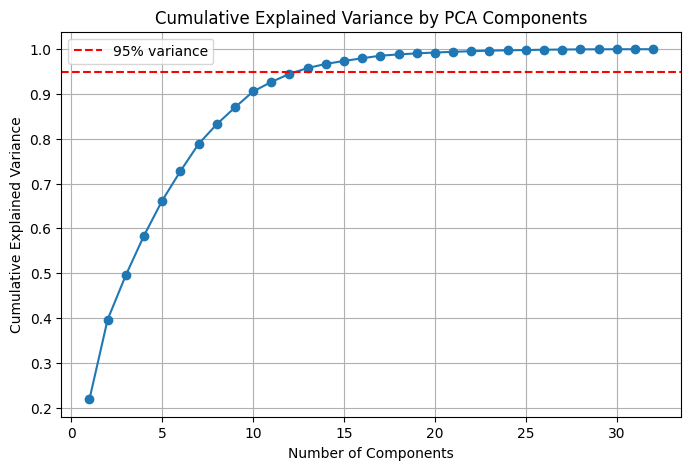

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance (sum of squared loadings)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("\nPCA Explained Variance Ratios:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.savefig('pca_variance.png')
plt.show()

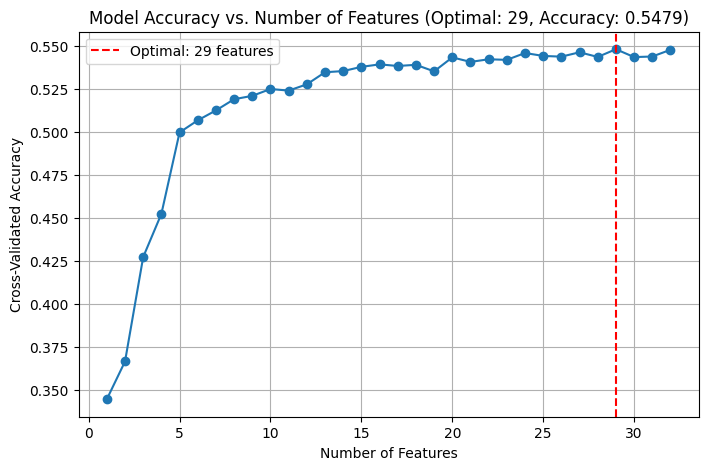

In [ ]:
# Step 5: Recursive Model Testing
remaining_features = importances[importances > 0].index.tolist()
scores = []
for n_features in range(1, len(remaining_features) + 1):
    top_features = remaining_features[:n_features]
    X_subset = X_filtered[top_features]
    rf = RandomForestClassifier(random_state=42)
    cv_score = cross_val_score(rf, X_subset, y, cv=5, scoring='accuracy').mean()
    scores.append({'N_Features': n_features, 'Accuracy': cv_score})

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores)
optimal_n = scores_df.loc[scores_df['Accuracy'].idxmax(), 'N_Features']
optimal_accuracy = scores_df['Accuracy'].max()

# Plot performance vs. number of features
plt.figure(figsize=(8, 5))
plt.plot(scores_df['N_Features'], scores_df['Accuracy'], marker='o')
plt.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal: {optimal_n} features')
plt.title(f'Model Accuracy vs. Number of Features (Optimal: {optimal_n}, Accuracy: {optimal_accuracy:.4f})')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid()
plt.savefig('feature_selection_accuracy.png')
plt.show()

XGBoost

In [ ]:
data_list = []
for org, df in dfs.items():
    temp = df.copy()
    temp['Organism'] = org
    data_list.append(temp)
full_df = pd.concat(data_list, ignore_index=True)

# Handle missing values (impute with median)
full_df.fillna(full_df.median(numeric_only=True), inplace=True)

# Features and target
X = full_df.drop('Organism', axis=1)
y = full_df['Organism']
features = X.columns  # 57 features

# Step 2: Correlation Analysis
corr_matrix = X.corr(method='pearson')
threshold = 0.95
to_drop = set()
corr_pairs = []

# Identify highly correlated pairs and mark features to drop
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            col_i, col_j = corr_matrix.columns[i], corr_matrix.columns[j]
            to_drop.add(col_i)  # Mark the second feature for potential discard
            corr_pairs.append({
                'Feature1': col_j,
                'Feature2': col_i,
                'Correlation': corr_value,
                'Discarded': col_i,
                'Retained': col_j
            })

# Create correlation pairs DataFrame
corr_pairs_df = pd.DataFrame(corr_pairs)
if not corr_pairs_df.empty:
    print(f"Highly correlated pairs (|corr| > {threshold}): {len(corr_pairs_df)}")
else:
    print("No highly correlated pairs found.")
    corr_pairs_df = pd.DataFrame(columns=['Feature1', 'Feature2', 'Correlation', 'Discarded', 'Retained'])

# Export correlation pairs to CSV
corr_pairs_df.to_csv('correlation_pairs.csv', index=False)
print("\nCorrelation pairs saved to 'correlation_pairs.csv'")

# Export full correlation matrix to CSV
corr_matrix.to_csv('correlation_matrix.csv')
print("Correlation matrix saved to 'correlation_matrix.csv'")

# Remove highly correlated features
X_filtered = X.drop(columns=to_drop)
print(f"\nRemoved {len(to_drop)} features due to high correlation: {to_drop}")
print(f"Remaining features: {list(X_filtered.columns)}, Total {len(X_filtered.columns)}")

Highly correlated pairs (|corr| > 0.95): 7

Correlation pairs saved to 'correlation_pairs.csv'
Correlation matrix saved to 'correlation_matrix.csv'

Removed 5 features due to high correlation: {'ND', 'G+C', '%A+U', 'D', 'A+U'}
Remaining features: ['Len', 'A', 'C', 'G', 'U', 'AA', 'AC', 'AG', 'AU', 'CA', 'CC', 'CG', 'CU', 'GA', 'GC', 'GG', 'GU', 'UA', 'UC', 'UG', 'UU', '%A', '%C', '%G', '%U', '%G+C', '%AA', '%AC', '%AG', '%AU', '%CA', '%CC', '%CG', '%CU', '%GA', '%GC', '%GG', '%GU', '%UA', '%UC', '%UG', '%UU', 'pb', 'Npb', 'mfe', 'dG', 'Q', 'NQ', 'MFE1', 'MFE2', 'MFE3', 'MFE4'], Total 52



PCA Explained Variance Ratios:
PC1: 0.2529 (0.2529 cumulative)
PC2: 0.2100 (0.4629 cumulative)
PC3: 0.0842 (0.5471 cumulative)
PC4: 0.0656 (0.6127 cumulative)
PC5: 0.0567 (0.6694 cumulative)
PC6: 0.0553 (0.7247 cumulative)
PC7: 0.0413 (0.7661 cumulative)
PC8: 0.0362 (0.8023 cumulative)
PC9: 0.0301 (0.8324 cumulative)
PC10: 0.0263 (0.8587 cumulative)
PC11: 0.0252 (0.8839 cumulative)
PC12: 0.0230 (0.9068 cumulative)
PC13: 0.0186 (0.9254 cumulative)
PC14: 0.0169 (0.9423 cumulative)
PC15: 0.0157 (0.9580 cumulative)
PC16: 0.0113 (0.9693 cumulative)
PC17: 0.0086 (0.9779 cumulative)
PC18: 0.0051 (0.9830 cumulative)
PC19: 0.0030 (0.9860 cumulative)
PC20: 0.0020 (0.9879 cumulative)
PC21: 0.0019 (0.9898 cumulative)
PC22: 0.0014 (0.9912 cumulative)
PC23: 0.0013 (0.9925 cumulative)
PC24: 0.0010 (0.9935 cumulative)
PC25: 0.0010 (0.9945 cumulative)
PC26: 0.0007 (0.9952 cumulative)
PC27: 0.0006 (0.9958 cumulative)
PC28: 0.0006 (0.9964 cumulative)
PC29: 0.0005 (0.9969 cumulative)
PC30: 0.0005 (0.9974

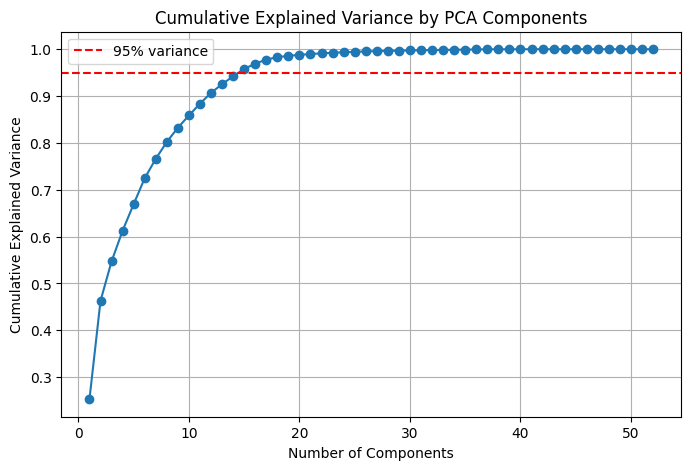

In [ ]:
# Step 3: Feature Importance with XGBoost
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_filtered, y_encoded)
importances = pd.Series(xgb_model.feature_importances_, index=X_filtered.columns)
importances = importances.sort_values(ascending=False)

# Step 4: PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("\nPCA Explained Variance Ratios:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.savefig('pca_variance_xgb.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume DataFrames are loaded
dfs = {
    'aves': aves_df,
    'human': human_df,
    'mammalia': mammalia_df,
    'monocots': monocots_df,
    'rodent': rodent_df,
    'rumin': rumin_df,
    'sauria': sauria_df,
    'insect': insect_df
}

# Step 1: Combine DataFrames
data_list = []
for org, df in dfs.items():
    temp = df.copy()
    temp['Organism'] = org
    data_list.append(temp)
full_df = pd.concat(data_list, ignore_index=True)


Training model for aves...

Training model for human...

Training model for mammalia...

Training model for monocots...

Training model for rodent...

Training model for rumin...

Training model for sauria...

Training model for insect...

=== Model Performance Summary ===
Organism  N_Samples    CV_F1  Test_F1  Test_Recall  Test_AUC
    aves       2762 0.710622 0.708995     0.728261  0.787278
   human       3832 0.701187 0.717172     0.741514  0.772125
mammalia       1004 0.717253 0.727273     0.760000  0.799208
monocots       1820 0.858087 0.823188     0.780220  0.924073
  rodent       3160 0.685055 0.712074     0.727848  0.794364
   rumin       2128 0.658887 0.641791     0.605634  0.712513
  sauria       1212 0.838704 0.903475     0.966942  0.945265
  insect       7710 0.856514 0.846547     0.858625  0.923000

Results saved to 'model_performance_results.csv'


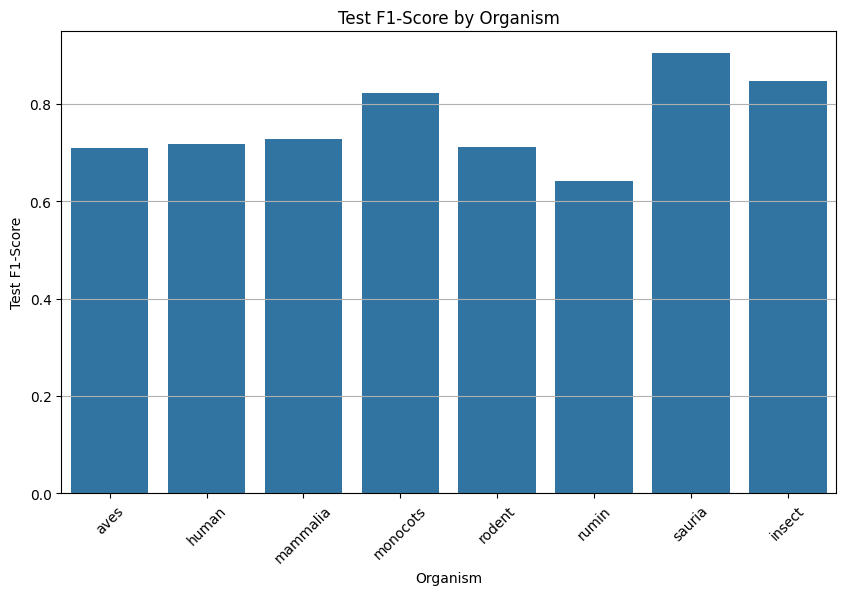

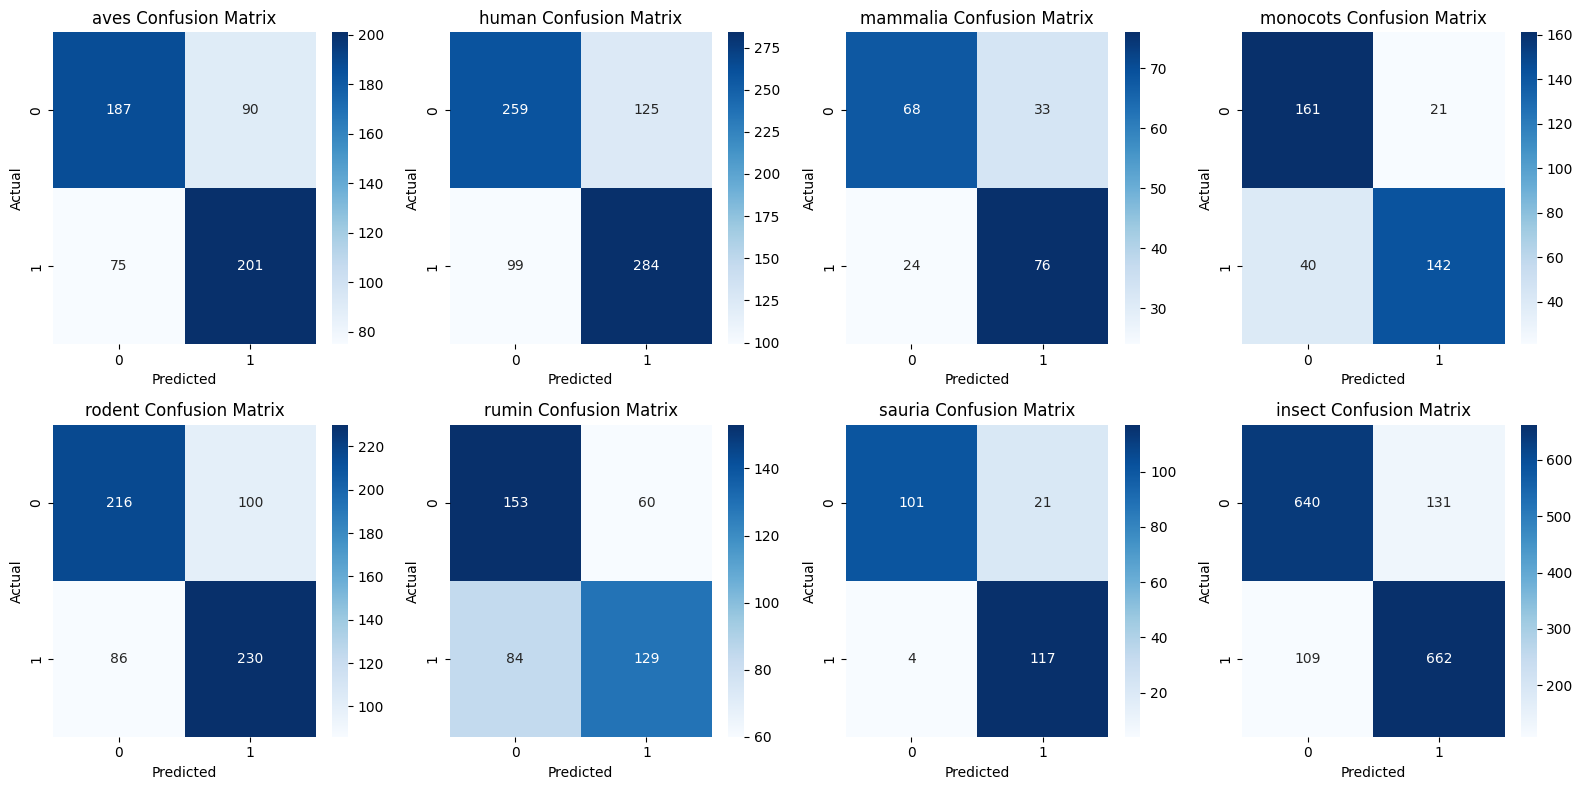

In [ ]:


# Handle missing values (impute with median)
full_df.fillna(full_df.median(numeric_only=True), inplace=True)

# Features and target (assume X_filtered columns from previous step)
y = full_df['Organism']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Assume X_filtered is the reduced feature set (PC1-PC14 features, excluding %A+U, etc.)
# Replace with actual feature list from your feature engineering output
# X_filtered = X  # Placeholder; update with actual PC1-PC14 features

# Step 2: Train and evaluate one model per organism
results = []
organisms = list(dfs.keys())

for target_org in organisms:
    print(f"\nTraining model for {target_org}...")

    # Create balanced dataset
    # Positive samples: all target organism samples
    pos_df = full_df[full_df['Organism'] == target_org]
    n_pos = len(pos_df)

    # Negative samples: randomly sample equal number from non-target organisms
    neg_df = full_df[full_df['Organism'] != target_org]
    neg_sample = neg_df.sample(n=n_pos, random_state=42, replace=False)

    # Combine positive and negative samples
    balanced_df = pd.concat([pos_df, neg_sample], ignore_index=True)
    X_balanced = balanced_df[X_filtered.columns]
    y_balanced = (balanced_df['Organism'] == target_org).astype(int)  # 1 for positive, 0 for negative

    # Split into train and test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')

    # Cross-validation on training set
    cv_f1 = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1').mean()
    cv_precision = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='precision').mean()
    cv_recall = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='recall').mean()
    cv_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy').mean()
    cv_auc = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    # Train on full training set and evaluate on test set
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    test_f1 = f1_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    results.append({
        'Organism': target_org,
        'N_Samples': n_pos * 2,  # Positive + negative
        'CV_F1': cv_f1,
        'CV_Precision': cv_precision,
        'CV_Recall': cv_recall,
        'CV_Accuracy': cv_accuracy,
        'CV_AUC': cv_auc,
        'Test_F1': test_f1,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_Accuracy': test_accuracy,
        'Test_AUC': test_auc,
        'Confusion_Matrix': conf_matrix.tolist()  # Store as list for CSV
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print("\n=== Model Performance Summary ===")
print(results_df[['Organism', 'N_Samples', 'CV_F1', 'Test_F1', 'Test_Recall', 'Test_AUC']].to_string(index=False))

# Save results
results_df.to_csv('model_performance_results.csv', index=False)
print("\nResults saved to 'model_performance_results.csv'")

# Visualize F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Organism', y='Test_F1', data=results_df)
plt.title('Test F1-Score by Organism')
plt.xlabel('Organism')
plt.ylabel('Test F1-Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('f1_scores_by_organism.png')
plt.show()

# Visualize confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, (org, cm) in enumerate(zip(results_df['Organism'], results_df['Confusion_Matrix'])):
    sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{org} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Train and evaluate one model per organism with nested CV
results = []
organisms = list(dfs.keys())

for target_org in organisms:
    print(f"\nTraining model for {target_org}...")

    # Create balanced dataset
    pos_df = full_df[full_df['Organism'] == target_org]
    n_pos = len(pos_df)
    neg_df = full_df[full_df['Organism'] != target_org]
    neg_sample = neg_df.sample(n=n_pos, random_state=42, replace=False)
    balanced_df = pd.concat([pos_df, neg_sample], ignore_index=True)
    X_balanced = balanced_df[X_filtered.columns]
    y_balanced = (balanced_df['Organism'] == target_org).astype(int)  # 1 for positive, 0 for negative

    # Reserve 10% independent test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.1, random_state=42, stratify=y_balanced
    )

    # Nested CV: outer loop for performance, inner loop for tuning
    outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1_scores, cv_precision_scores, cv_recall_scores, cv_accuracy_scores, cv_auc_scores = [], [], [], [], []

    for train_idx, val_idx in outer_kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Inner CV for hyperparameter tuning
        param_grid = {
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'n_estimators': [100, 200]
        }
        xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
        grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Best model from inner CV
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]

        # Store outer CV metrics
        cv_f1_scores.append(f1_score(y_val, y_pred))
        cv_precision_scores.append(precision_score(y_val, y_pred))
        cv_recall_scores.append(recall_score(y_val, y_pred))
        cv_accuracy_scores.append(accuracy_score(y_val, y_pred))
        cv_auc_scores.append(roc_auc_score(y_val, y_pred_proba))

    # Train final model on full train_val set with best hyperparameters
    final_model = grid_search.best_estimator_
    final_model.fit(X_train_val, y_train_val)

    # Evaluate on independent test set
    y_test_pred = final_model.predict(X_test)
    y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store results
    results.append({
        'Organism': target_org,
        'N_Samples': n_pos * 2,
        'CV_F1_Mean': np.mean(cv_f1_scores),
        'CV_F1_Std': np.std(cv_f1_scores),
        'CV_Recall_Mean': np.mean(cv_recall_scores),
        'CV_Recall_Std': np.std(cv_recall_scores),
        'CV_Precision_Mean': np.mean(cv_precision_scores),
        'CV_Precision_Std': np.std(cv_precision_scores),
        'CV_Accuracy_Mean': np.mean(cv_accuracy_scores),
        'CV_Accuracy_Std': np.std(cv_accuracy_scores),
        'CV_AUC_Mean': np.mean(cv_auc_scores),
        'CV_AUC_Std': np.std(cv_auc_scores),
        'Test_F1': test_f1,
        'Test_Recall': test_recall,
        'Test_Precision': test_precision,
        'Test_Accuracy': test_accuracy,
        'Test_AUC': test_auc,
        'Confusion_Matrix': test_conf_matrix.tolist(),
        'Best_Params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print("\n=== Model Performance Summary ===")
print(results_df[['Organism', 'N_Samples', 'CV_F1_Mean', 'CV_F1_Std', 'Test_F1', 'Test_Recall']].to_string(index=False))

# Save results
results_df.to_csv('model_performance_results_nested_cv.csv', index=False)
print("\nResults saved to 'model_performance_results_nested_cv.csv'")

# Visualize F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Organism', y='Test_F1', data=results_df)
plt.title('Test F1-Score by Organism (Nested CV + Independent Test Set)')
plt.xlabel('Organism')
plt.ylabel('Test F1-Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('f1_scores_by_organism_nested_cv.png')
plt.show()

# Visualize confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, (org, cm) in enumerate(zip(results_df['Organism'], results_df['Confusion_Matrix'])):
    sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{org} Confusion Matrix (Test Set)')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices_nested_cv.png')
plt.show()


Training model for aves...


KeyError: '[2, 10, 15, 28, 36, 37, 38, 39, 53, 60, 61, 114, 130, 145, 159, 169, 182, 186, 187, 215, 217, 223, 225, 244, 250, 258, 265, 271, 292, 310, 317, 323, 327, 328, 339, 348, 363, 375, 376, 388, 398, 413, 418, 431, 453, 476, 492, 496, 505, 520, 545, 563, 576, 579, 584, 592, 614, 619, 634, 688, 689, 696, 704, 709, 721, 726, 737, 738, 747, 752, 758, 771, 780, 795, 804, 806, 813, 816, 824, 849, 884, 892, 893, 913, 920, 925, 935, 936, 938, 948, 951, 954, 957, 963, 972, 974, 981, 982, 983, 985, 987, 994, 1043, 1062, 1063, 1085, 1112, 1121, 1122, 1130, 1143, 1147, 1163, 1164, 1168, 1176, 1182, 1184, 1199, 1218, 1249, 1252, 1262, 1296, 1297, 1306, 1327, 1331, 1340, 1394, 1395, 1401, 1402, 1415, 1421, 1445, 1468, 1472, 1476, 1479, 1502, 1511, 1515, 1542, 1568, 1570, 1581, 1582, 1586, 1587, 1597, 1611, 1622, 1633, 1650, 1657, 1669, 1676, 1696, 1718, 1759, 1760, 1766, 1768, 1773, 1782, 1787, 1799, 1847, 1855, 1865, 1873, 1883, 1889, 1944, 1946, 1973, 1981, 1993, 2023, 2027, 2028, 2067, 2080, 2083, 2100, 2106, 2110, 2123, 2128, 2144, 2147, 2150, 2156, 2157, 2160, 2175, 2185, 2196, 2221, 2237, 2251, 2252, 2259, 2272, 2278, 2310, 2336, 2338, 2341, 2356, 2376, 2397, 2398, 2401, 2406, 2409, 2419, 2425, 2432, 2437, 2445, 2452, 2457, 2463, 2467, 2476] not in index'

In [ ]:
# Nested CV: outer loop for performance, inner loop for tuning
outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_f1_scores, cv_precision_scores, cv_recall_scores, cv_accuracy_scores, cv_auc_scores = [], [], [], [], []

for train_idx, val_idx in outer_kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]  # Direct indexing for NumPy array/Series

    # Inner CV for hyperparameter tuning
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'n_estimators': [100, 200]
    }
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model from inner CV
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]

    # Store outer CV metrics
    cv_f1_scores.append(f1_score(y_val, y_pred))
    cv_precision_scores.append(precision_score(y_val, y_pred))
    cv_recall_scores.append(recall_score(y_val, y_pred))
    cv_accuracy_scores.append(accuracy_score(y_val, y_pred))
    cv_auc_scores.append(roc_auc_score(y_val, y_pred_proba))

KeyError: '[2, 10, 15, 28, 36, 37, 38, 39, 53, 60, 61, 114, 130, 145, 159, 169, 182, 186, 187, 215, 217, 223, 225, 244, 250, 258, 265, 271, 292, 310, 317, 323, 327, 328, 339, 348, 363, 375, 376, 388, 398, 413, 418, 431, 453, 476, 492, 496, 505, 520, 545, 563, 576, 579, 584, 592, 614, 619, 634, 688, 689, 696, 704, 709, 721, 726, 737, 738, 747, 752, 758, 771, 780, 795, 804, 806, 813, 816, 824, 849, 884, 892, 893, 913, 920, 925, 935, 936, 938, 948, 951, 954, 957, 963, 972, 974, 981, 982, 983, 985, 987, 994, 1043, 1062, 1063, 1085, 1112, 1121, 1122, 1130, 1143, 1147, 1163, 1164, 1168, 1176, 1182, 1184, 1199, 1218, 1249, 1252, 1262, 1296, 1297, 1306, 1327, 1331, 1340, 1394, 1395, 1401, 1402, 1415, 1421, 1445, 1468, 1472, 1476, 1479, 1502, 1511, 1515, 1542, 1568, 1570, 1581, 1582, 1586, 1587, 1597, 1611, 1622, 1633, 1650, 1657, 1669, 1676, 1696, 1718, 1759, 1760, 1766, 1768, 1773, 1782, 1787, 1799, 1847, 1855, 1865, 1873, 1883, 1889, 1944, 1946, 1973, 1981, 1993, 2023, 2027, 2028, 2067, 2080, 2083, 2100, 2106, 2110, 2123, 2128, 2144, 2147, 2150, 2156, 2157, 2160, 2175, 2185, 2196, 2221, 2237, 2251, 2252, 2259, 2272, 2278, 2310, 2336, 2338, 2341, 2356, 2376, 2397, 2398, 2401, 2406, 2409, 2419, 2425, 2432, 2437, 2445, 2452, 2457, 2463, 2467, 2476] not in index'

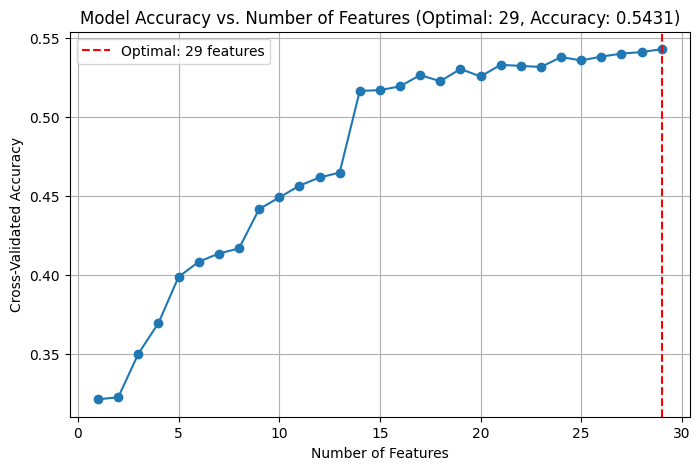


Feature selection results saved to 'feature_selection_results_xgb_pca.csv'
Optimal number of features: 29 with accuracy: 0.5431
Selected features (PC1-PC14): ['Npb', 'MFE2', 'MFE3', 'NQ', '%AU', '%C', 'dG', '%U', 'mfe', '%A', 'UA', '%UC', 'MFE1', '%CG', 'AC', 'GU', '%CU', '%UA', 'GC', '%GA', '%AA', '%CA', 'CC', 'UU', 'AU', '%GG', '%GU', '%G+C', 'Len']


In [ ]:

# Get PCA loadings
loadings = pd.DataFrame(pca.components_.T, index=X_filtered.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Select top features contributing to PC1-PC14
n_components = 40  # Based on cumulative variance < 95%
top_features = set()
for i in range(n_components):
    pc_loadings = loadings[f'PC{i+1}'].abs()
    # Select features with highest absolute loadings for each component
    top_feature = pc_loadings.idxmax()
    top_features.add(top_feature)

# Convert to list and sort by contribution to PC1-PC14
top_features = list(top_features)
# Sort features based on their maximum absolute loading across PC1-PC14
feature_scores = loadings.loc[top_features, [f'PC{i+1}' for i in range(n_components)]].abs().max(axis=1)
top_features = feature_scores.sort_values(ascending=False).index.tolist()

# Recursive testing
scores = []
for n_features in range(1, len(top_features) + 1):
    subset_features = top_features[:n_features]
    X_subset = X_filtered[subset_features]
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
    cv_score = cross_val_score(xgb_model, X_subset, y_encoded, cv=5, scoring='accuracy').mean()
    scores.append({'N_Features': n_features, 'Accuracy': cv_score})

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores)
optimal_n = scores_df.loc[scores_df['Accuracy'].idxmax(), 'N_Features']
optimal_accuracy = scores_df['Accuracy'].max()

# Plot performance vs. number of features
plt.figure(figsize=(8, 5))
plt.plot(scores_df['N_Features'], scores_df['Accuracy'], marker='o')
plt.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal: {optimal_n} features')
plt.title(f'Model Accuracy vs. Number of Features (Optimal: {optimal_n}, Accuracy: {optimal_accuracy:.4f})')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid()
plt.savefig('feature_selection_accuracy_xgb_pca.png')
plt.show()

# Save results
scores_df.to_csv('feature_selection_results_xgb_pca.csv', index=False)
print("\nFeature selection results saved to 'feature_selection_results_xgb_pca.csv'")
print(f"Optimal number of features: {optimal_n} with accuracy: {optimal_accuracy:.4f}")
print(f"Selected features (PC1-PC14): {top_features[:optimal_n]}")

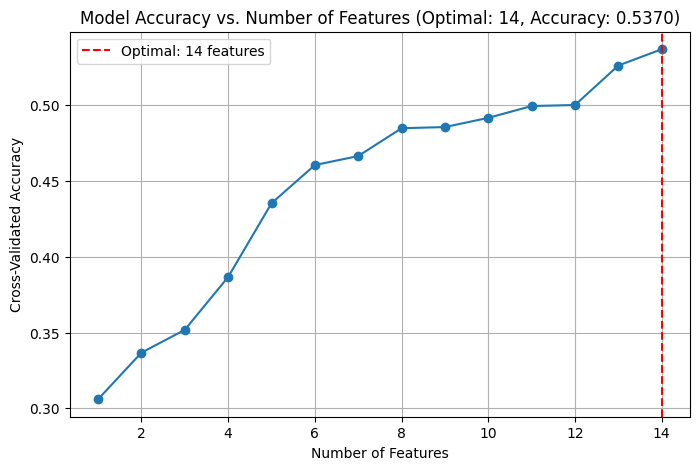


Feature selection results saved to 'feature_selection_results_xgb_pca.csv'
Optimal number of features: 14 with accuracy: 0.5370
Selected features (PC1-PC14): ['NQ', '%AU', '%UC', 'MFE1', '%CG', '%UA', '%GA', '%AA', '%CA', '%GG', '%GU', '%CU', 'Len', '%G+C']


In [ ]:
# Step 3: Feature Importance with XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_filtered, y_encoded)
importances = pd.Series(xgb_model.feature_importances_, index=X_filtered.columns)
importances = importances.sort_values(ascending=False)

# Step 5: Recursive Model Testing with PCA-based Features
# Get PCA loadings
loadings = pd.DataFrame(pca.components_.T, index=X_filtered.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Select top features contributing to PC1-PC14
n_components = 14  # Based on cumulative variance < 95%
top_features = set()
for i in range(n_components):
    pc_loadings = loadings[f'PC{i+1}'].abs()
    # Select features with highest absolute loadings for each component
    top_feature = pc_loadings.idxmax()
    top_features.add(top_feature)

# Convert to list and sort by contribution to PC1-PC14
top_features = list(top_features)
# Sort features based on their maximum absolute loading across PC1-PC14
feature_scores = loadings.loc[top_features, [f'PC{i+1}' for i in range(n_components)]].abs().max(axis=1)
top_features = feature_scores.sort_values(ascending=False).index.tolist()

# Recursive testing
scores = []
for n_features in range(1, len(top_features) + 1):
    subset_features = top_features[:n_features]
    X_subset = X_filtered[subset_features]
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
    cv_score = cross_val_score(xgb_model, X_subset, y_encoded, cv=5, scoring='accuracy').mean()
    scores.append({'N_Features': n_features, 'Accuracy': cv_score})

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores)
optimal_n = scores_df.loc[scores_df['Accuracy'].idxmax(), 'N_Features']
optimal_accuracy = scores_df['Accuracy'].max()

# Plot performance vs. number of features
plt.figure(figsize=(8, 5))
plt.plot(scores_df['N_Features'], scores_df['Accuracy'], marker='o')
plt.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal: {optimal_n} features')
plt.title(f'Model Accuracy vs. Number of Features (Optimal: {optimal_n}, Accuracy: {optimal_accuracy:.4f})')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid()
plt.savefig('feature_selection_accuracy_xgb_pca.png')
plt.show()

# Save results
scores_df.to_csv('feature_selection_results_xgb_pca.csv', index=False)
print("\nFeature selection results saved to 'feature_selection_results_xgb_pca.csv'")
print(f"Optimal number of features: {optimal_n} with accuracy: {optimal_accuracy:.4f}")
print(f"Selected features (PC1-PC14): {top_features[:optimal_n]}")